In [22]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import pandas as pd
import datetime
from matplotlib import pyplot as plt

import tqdm.notebook as nb
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.ticker as mtick
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rc('font', family='serif', serif='Times')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=10)

# width as measured in inkscape
width = 3.125
height = width / 1.618

# Probability of survival from nomination for deletion

In [ ]:
all_biographies2 = pd.read_csv('data/processed/all_biographies2.csv', index_col=False)

In [ ]:
survival_data_male = all_biographies2[all_biographies2['gender']=='male']
survival_data_female = all_biographies2[all_biographies2['gender']=='female']

kmf_male = KaplanMeierFitter(label='Men')
kmf_female = KaplanMeierFitter(label='Women')


kmf_male = kmf_male.fit(durations=survival_data_male['days_before_nomination'], event_observed=survival_data_male['nominated'])
kmf_female = kmf_female.fit(durations=survival_data_female['days_before_nomination'], event_observed=survival_data_female['nominated'])

In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=.18, bottom=.2, right=.99, top=.97)

kmf_male.plot(color='blue')
kmf_female.plot(color='red')
ax.set_xlabel('Days before Nomination')

ax.set_ylabel('Probability of Survival')
fig.set_size_inches(width, height)
fig.savefig('reports/figures/Male_vs_Female_Survival.png', dpi=200)
fig.show()

# Merge with Living People set 


In [ ]:
print("Loading list of Living People...")
BLP=pd.read_csv('data/petscan/Living_people.csv', index_col=False)
BLP=BLP[['title']]

print("Merging All biographies with Living people...")
all_biographies2_BLP=pd.merge(all_biographies2,BLP, left_on='page_title',right_on='title', how='left')
all_biographies2_BLP['BLP']= all_biographies2_BLP['title'].fillna(0)
all_biographies2_BLP['Entry2']=all_biographies2_BLP['Entry'].apply(lambda x: x.replace(" ","_"))
all_biographies2_BLP.loc[all_biographies2_BLP[(all_biographies2_BLP['Entry2'].isin(BLP['title'])) & (all_biographies2_BLP['BLP']==0)].index,'BLP'] =1
all_biographies2_BLP.loc[all_biographies2_BLP['BLP']!=0,'BLP']=1


print("Recoding Gender covariate...")
all_biographies2_BLP.loc[all_biographies2_BLP['gender']=='female','Female']=1
all_biographies2_BLP.loc[all_biographies2_BLP['gender']!='female','Female']=0


print("Formating date of birth and death...")
all_biographies2_BLP['birth']=all_biographies2_BLP['date_of_birth'].apply(lambda x: -1*int(x.split('-')[1]) if x[0]=='-' else( int(x.split('-')[0] ) if len(x.split('-')[0])==4 else ( int(x.split('-')[0]) if x[0]=='+' else 'no data') ) )
all_biographies2_BLP['death']=all_biographies2_BLP['date_of_death'].apply(lambda x: -1*int(x.split('-')[1]) if x[0]=='-' else( int(x.split('-')[0] ) if len(x.split('-')[0])==4 else ( int(x.split('-')[0]) if x[0]=='+' else 'no data') ) )


print("Splitting dataset based on the availability of dates of birth and death")
part_1=all_biographies2_BLP[all_biographies2_BLP['death']!='no data']
part_2=all_biographies2_BLP[(all_biographies2_BLP['birth']!='no data') & (all_biographies2_BLP['death']=='no data')]
part_3=all_biographies2_BLP[(all_biographies2_BLP['birth']=='no data') & (all_biographies2_BLP['death']=='no data')]

In [ ]:
len(all_biographies2_BLP), len(part_1),len(part_2), len(part_3), len(part_1)+len(part_2)+ len(part_3)

#### Fix the data with death data

In [ ]:
print("Part 1: Set up and process the data, focusing on entries that include a recorded date of death...")
part_1['Alive']=0

print("Splitting data based on availbility of date of birth...")
part_1A=part_1[part_1['birth']!='no data']
part_1B=part_1[part_1['birth']=='no data']

print("Removing data with wrong date of birth..")
part_1A['wrong']=part_1A.apply(lambda row: 1 if int(str(row['creation_date_original2'])[:4])< row['birth'] else 0,axis=1)
part_1A=part_1A[part_1A['wrong']==0]
part_1A=part_1A.drop(columns=['wrong'])

print("Identifying date of birth of the people who are dead...")
part_1B['birth']=part_1B['death'].apply(lambda x: x-70)

part_1=pd.concat([part_1A,part_1B])

print("Identifying the living people at the time of nomination who are deceased after 2000...")
part_1_after2000=part_1[part_1['death']>=2000]
part_1_before2000=part_1[part_1['death']<2000]
part_1_after2000['Alive']=part_1_after2000.apply(lambda row: 1 if pd.to_datetime(row['nomination_dates'],utc=True)< pd.to_datetime(str(row['death']).replace("+",""), utc=True) else 0,axis=1)



part_1=pd.concat([part_1_before2000,part_1_after2000])
print("Done with Part 1!")


In [ ]:
len(part_1)

#### Fix the data with birth date but no death date

In [ ]:
len(part_2)

In [ ]:
print("Part 2: Set up and correct the data, ensuring entries with a birth date but no death date are properly handled...\n")
print("Removing data with wrong date of birth...\n")
part_2['wrong']=part_2.apply(lambda row: 1 if int(str(row['creation_date_original2'])[:4])< row['birth'] else 0,axis=1)
part_2=part_2[part_2['wrong']==0]
part_2=part_2.drop(columns=['wrong'])

print("Identifying people born before 1907...\n")
part_2C=part_2[part_2['birth']<1907]
part_2C['Alive']=0

print("Identifying people born after 1907 and alive...\n")
part_2_notC = part_2[part_2['birth']>=1907]
part_2A = part_2_notC[part_2_notC['BLP']==1]
part_2A['Alive']=1

print("Identifying people born after 1907 and deceased...\n")
part_2B = part_2_notC[part_2_notC['BLP']==0]
dead=pd.read_csv('data/petscan/Dead_people_all.csv',error_bad_lines=False, index_col=False)
part_2B_a=part_2B[part_2B['page_title'].isin(dead['title'])].drop_duplicates(subset='page_title', keep='first')
part_2B_a['Alive']=0
part_2B_b=part_2B[~part_2B['page_title'].isin(dead['title'])].drop_duplicates(subset='page_title', keep='first')
part_2B_b['Alive']=1

part_2=pd.concat([part_2A,part_2B_a,part_2B_b,part_2C])
print("Done with Part 2!\n")

In [ ]:
len(part_2)

#### Fix the data with no birth date and no death date

In [ ]:
len(part_3)

In [ ]:
print("Identifying living people...\n")
part_3A = part_3[part_3['BLP']==1]
part_3A['Alive']=1
part_3A['is_Historical']=0
part_3B = part_3[part_3['BLP']==0]
# part_3B['Alive']=0

if cutoff 1800

In [ ]:
birth_from_begin_till_17th_century=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/birth_from_begin_till_17th_century.csv',error_bad_lines=False, index_col=False)
birth_18thcentury=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/birth_18thcentury.csv',error_bad_lines=False, index_col=False)


In [ ]:
historical_people = pd.concat([birth_from_begin_till_17th_century,birth_18thcentury])

In [ ]:
conteporary_people=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/birth_19th_century_to_3rd_Millenium.csv',error_bad_lines=False, index_col=False)


If cutoff 1945

In [ ]:
birth_from_begin_till_1st_millenium=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/birth_from_begin_till_1st_millenium.csv',error_bad_lines=False, index_col=False)
birth_2nd_millenium_without_20th_century=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/birth_2nd_millenium_without_20th_century.csv',error_bad_lines=False, index_col=False)
birth_from1900s_to_1945=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/birth_from1900s_to_1945.csv',error_bad_lines=False, index_col=False)



In [ ]:
historical_people = pd.concat([birth_from_begin_till_1st_millenium,birth_2nd_millenium_without_20th_century,birth_from1900s_to_1945])

In [ ]:
conteporary_people=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/birth_19th_century_to_3rd_Millenium.csv',error_bad_lines=False, index_col=False)

If cutoff 1907

In [ ]:
print("Identifying living and historical status based on birth by decades...\n")

print("collect data with date of birth before 1907...\n")
birth_from_begin_till_1st_millenium=pd.read_csv('data/petscan/birth_from_begin_till_1st_millenium.csv',error_bad_lines=False, index_col=False)
birth_2nd_millenium_without_20th_century=pd.read_csv('data/petscan/birth_2nd_millenium_without_20th_century.csv',error_bad_lines=False, index_col=False)
birth_1900s_without_07_08_09=pd.read_csv('data/petscan/birth_1900s_without_07,08,09.csv',error_bad_lines=False, index_col=False)



len(birth_from_begin_till_1st_millenium), len(birth_2nd_millenium_without_20th_century)

print("collect data with date of birth after 1907...\n")
birth_1907_08_09=pd.read_csv('data/petscan/birth_1907,08,09.csv',error_bad_lines=False, index_col=False)
birth_20th_century_without_1900s=pd.read_csv('data/petscan/birth_20th_century_without_1900s.csv',error_bad_lines=False, index_col=False)
birth_21st_century=pd.read_csv('data/petscan/birth_21st-century.csv',error_bad_lines=False, index_col=False)


historical_people = pd.concat([birth_from_begin_till_1st_millenium,birth_2nd_millenium_without_20th_century,birth_1900s_without_07_08_09])

contemporary_people = pd.concat([birth_1907_08_09,birth_20th_century_without_1900s,birth_21st_century])

print("Identifying historical people...\n")
part_3B_a=part_3B[part_3B['page_title'].isin(historical_people['title'])]
part_3B_a['Alive']=0
part_3B_a['is_Historical']=1

print("Identifying contemporary deceased people...\n")
part_3B_b=part_3B[~part_3B['page_title'].isin(historical_people['title'])]
part_3B_b_contemporary=part_3B_b[part_3B_b['page_title'].isin(contemporary_people['title'])]
dead=pd.read_csv('data/petscan/Dead_people_all.csv',error_bad_lines=False, index_col=False)
part_3B_b_contemporary_dead=part_3B_b_contemporary[part_3B_b_contemporary['page_title'].isin(dead['title'])]
part_3B_b_contemporary_dead['Alive']=0
part_3B_b_contemporary_dead['is_Historical']=0

print("Identifying data without date of birth and death information...\n")
Totally_unlnown_group = pd.concat([part_3B_b[~part_3B_b['page_title'].isin(contemporary_people['title'])],part_3B_b_contemporary[~part_3B_b_contemporary['page_title'].isin(dead['title'])]])

print("Identifying people deceased before 1907...\n")
dead_historical=pd.read_csv('data/petscan/Dead_people_historical.csv',error_bad_lines=False, index_col=False)
part_3B_unknown_historical_dead=Totally_unlnown_group[Totally_unlnown_group['page_title'].isin(dead_historical['title'])]
part_3B_unknown_historical_dead['Alive']=0
part_3B_unknown_historical_dead['is_Historical']=1


part_3_better=pd.concat([part_3A,part_3B_a,part_3B_b_contemporary_dead, part_3B_unknown_historical_dead])
not_part_3=part_3[~part_3['page_title'].isin(part_3_better['page_title'])]

print("Identifying people deceased after 1907...\n")
Dead_people_from1900_to1977=pd.read_csv('data/petscan/Dead_people_from1900_to1977.csv',error_bad_lines=False, index_col=False)
dead_contemporary_2=dead[~dead['title'].isin(pd.concat([dead_historical,Dead_people_from1900_to1977])['title'])]

print("Consider the rest of people as alive...\n")
probably_alive=not_part_3[~not_part_3['page_title'].isin(dead_contemporary_2['title'])]
probably_alive['Alive']=1
probably_alive['is_Historical']=0

part_3_better=pd.concat([part_3_better,probably_alive])



In [ ]:
Totally_unlnown_group

if cutoff 1800

In [ ]:
death_from_begin_till_18th_century=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/death_from_begin_till_18th_century.csv',error_bad_lines=False, index_col=False)
death_from_1800s_to_1870s=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/death_from_1800s_to_1870s.csv',error_bad_lines=False, index_col=False)


In [ ]:
dead_historical = pd.concat([death_from_begin_till_18th_century,death_from_1800s_to_1870s])

In [ ]:
len(dead_historical)

if cutoff 1907

In [ ]:
print("Identifying people deceased before 1907...\n")
dead_historical=pd.read_csv('data/petscan/Dead_people_historical.csv',error_bad_lines=False, index_col=False)
part_3B_unknown_historical_dead=Totally_unlnown_group[Totally_unlnown_group['page_title'].isin(dead_historical['title'])]
part_3B_unknown_historical_dead['Alive']=0
part_3B_unknown_historical_dead['is_Historical']=1


part_3_better=pd.concat([part_3A,part_3B_a,part_3B_b_contemporary_dead, part_3B_unknown_historical_dead])
not_part_3=part_3[~part_3['page_title'].isin(part_3_better['page_title'])]

In [ ]:
not_part_3['nominated'].value_counts()

if cutoff 1800

In [ ]:
death_1880s_to_3rd_millenium=pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/death_1880s_to_3rd_millenium.csv',error_bad_lines=False, index_col=False)


In [ ]:
contemporary_dead=not_part_3[not_part_3['page_title'].isin(death_1880s_to_3rd_millenium['title'])]

In [ ]:
contemporary_dead['Alive']=0
contemporary_dead['Historical']=0

In [ ]:
part_3_better

In [ ]:
probably_alive=not_part_3[~not_part_3['page_title'].isin(contemporary_dead['title'])]

In [ ]:
probably_alive

In [ ]:
len(all_biographies2_with_data)+len(probably_alive)

if cutoff 1907

In [ ]:
len(not_part_3)/len(all_biographies2_BLP)

In [ ]:
print("Identifying people deceased after 1907...\n")
Dead_people_from1900_to1977=pd.read_csv('data/petscan/Dead_people_from1900_to1977.csv',error_bad_lines=False, index_col=False)
dead_contemporary_2=dead[~dead['title'].isin(pd.concat([dead_historical,Dead_people_from1900_to1977])['title'])]

print("Consider the rest of people as alive...\n")
probably_alive=not_part_3[~not_part_3['page_title'].isin(dead_contemporary_2['title'])]
probably_alive['Alive']=1
probably_alive['is_Historical']=0

part_3_better=pd.concat([part_3_better,probably_alive])

In [ ]:
part_3_better['is_Historical'].value_counts()

In [ ]:
part_3_better['Alive'].value_counts()

#### Concat all parts 

In [ ]:
print(len(part_1), len(part_2), len(part_3_better))

In [ ]:
len(part_3_better), len(part_3)

In [ ]:
part_1[['Entry','birth','death','Alive']]

In [ ]:
part_2[['Entry','birth','death','Alive']]

In [ ]:
len(all_biographies2_BLP),len(part_1) + len(part_2) 

In [ ]:
print("Join all the data...\n")
all_biographies2_with_data=pd.concat([part_1,part_2])
all_biographies2_with_data.loc[all_biographies2_with_data[all_biographies2_with_data['birth']>=1907].index,'is_Historical']=0
all_biographies2_with_data.loc[all_biographies2_with_data[all_biographies2_with_data['birth']<1907].index,'is_Historical']=1
all_biographies2_with_data=pd.concat([all_biographies2_with_data, part_3_better]).drop_duplicates(subset='page_title', keep='first')

In [ ]:
all_biographies2_with_data['is_Historical'].value_counts()

In [ ]:
all_biographies2_with_data['is_Historical'].value_counts()

In [ ]:
all_biographies2_with_data

In [ ]:
all_biographies2_with_data = pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/all_biographies2_with_data_without_history_level.csv', index_col=False)

# Study From Here 

In [ ]:
annotation_status = pd.read_csv('csv_files/data_Gender_bias/data_survival_analysis/Annotation_Status - Annotated_Status.csv', index_col=False)

In [ ]:
len(annotation_status)

In [ ]:
annotation_status.head()

In [ ]:
annotation_status.columns

In [ ]:
no_annotation_status=annotation_status[annotation_status['Alive']=='dont know']

In [ ]:
annotation_status=annotation_status[annotation_status['Alive']!='dont know']

In [ ]:
len(no_annotation_status)

In [ ]:
annotation_status['Status']=annotation_status.apply(lambda row: "Historical" if row['is_Historical']==1 else ("Contemporary Dead" if row['Alive']==0 else "Alive"), axis=1)


In [ ]:
sample_merge_evaluation=pd.merge(annotation_status[['page_title','QID','Status','birth']], all_biographies2_with_data[['page_title','QID','Status']], on = 'QID')

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(sample_merge_evaluation['Status_x'],sample_merge_evaluation['Status_y']))

In [ ]:
len(annotation_status)/len(all_biographies2_with_data)

# Cox regression analysis

In [ ]:
all_biographies2_with_data = pd.read_csv('data/processed/all_biographies2_with_data.csv', index_col=False)

In [ ]:
all_biographies2_with_data.head()

In [ ]:
fused_var_model = CoxPHFitter()
fused_var_model.fit(all_biographies2_with_data[['days_before_nomination','nominated','Gender', 'Wikipedia_Age','Status']].sample(frac=1), duration_col='days_before_nomination', event_col='nominated', formula="Gender + Wikipedia_Age + Status")

fused_var_model_interaction = CoxPHFitter()
fused_var_model_interaction.fit(all_biographies2_with_data[['days_before_nomination','nominated','Gender', 'Wikipedia_Age','Status']].sample(frac=1), duration_col='days_before_nomination', event_col='nominated', formula="Gender + Wikipedia_Age + Status + Gender*Status")


In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=.58, bottom=.2, right=.99, top=.97)

fused_var_model.plot(ax=ax)
ax.set_xlim((-3,1))

fig.set_size_inches(width, height)

fig.savefig('reports/figures/Cox_prop_model.png', dpi=200)


In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=.58, bottom=.2, right=.99, top=.97)

fused_var_model_interaction.plot(ax=ax)
ax.set_xlim((-3,1))

fig.set_size_inches(width, height)
fig.savefig('reports/figures/Cox_prop_model_interaction.png', dpi=200)


In [ ]:
fused_var_model.print_summary()

In [ ]:
fused_var_model_interaction.print_summary()

In [ ]:
%matplotlib inline

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True,sharey=True)
fig.subplots_adjust(left=.17, bottom=.16, right=.99, top=.97)


cycler = plt.cycler(linestyle=[':', "--", "-",':', "--", "-"],
                    color = ['blue','blue','blue','red','red', 'red'],
)
ax[0].set_prop_cycle(cycler)

fused_var_model.plot_partial_effects_on_outcome(covariates=['Gender','Status'],
                                               values=[[0,'Historical'],[0,'Contemporary Dead'],[0,'Alive'],[1,'Historical'],[1,'Contemporary Dead'],[1,'Alive']],
                                               color = ['blue','blue','blue','red','red', 'red'],
                                                      
                                               ax=ax[0]
                                                       
                                             
                                              )
ax[0].set_ylabel('Probability of Survival')
ax[0].legend(labels=['Men Historical','Men Contemporary Dead','Men Alive','Women Historical','Women Contemporary Dead','Women  Alive'], 
             loc='best', bbox_to_anchor=(3.6, 1), fontsize='x-small')


ax[1].set_prop_cycle(cycler)

fused_var_model_interaction.plot_partial_effects_on_outcome(covariates=['Gender','Status'],
                                               values=[[0,'Historical'],[0,'Contemporary Dead'],[0,'Alive'],[1,'Historical'],[1,'Contemporary Dead'],[1,'Alive']],
                                               color = ['blue','blue','blue','red','red', 'red'],
                                                      
                                               ax=ax[1]
                                                       
                                             
                                              )
ax[1].set_ylabel('Probability of Survival')
ax[1].legend('',frameon=False)
fig.text(0.3,0,'Days before Nomination', ha='left')

fig.set_size_inches(width, height)
fig.savefig('reports/figures/marginal_effect.png', bbox_inches='tight',dpi=200)


In [ ]:
from scipy.stats.distributions import chi2
def likelihood_ratio(llmin, llmax):
    return(2*(llmax-llmin))

L1 = 33195.48


L2 = 33434.42


LR = likelihood_ratio(L1,L2)


p = chi2.sf(LR, 1) # L2 has 1 DoF more than L1

print('p: %.30f' % p )

# p: 0.000000121315450836607258011741

# Experiment with Decision

In [ ]:
# data_for_compete_risk_nominated['event'].apply(lambda x:x.replace("<span style=\"color:red;\">","")
#                                                .replace("</span>","")
#                                                .replace("<font color=green>","")
#                                                .replace("</font>","")
#                                                .replace("<font color=red>","")
#                                                .replace("<s>","")
#                                                .replace("</s>","")                                          
#                                                .replace(".","")
#                                                .replace(":","")
#                                                .replace(",","")
#                                                .replace("deleted","delete")
#                                                .replace("deletion","delete")
#                                                .replace("[[wpsoftdelete|","")
#                                                .replace("delete]]","delete")
#                                                .replace("kept","keep")
#                                                .replace("redirected","redirect")
#                                                .replace("speedily ","")
#                                                .replace("speedy ","")
#                                                .replace("soft ","")
#                                                .replace("weak ","")
#                                                .replace("snow ","")
#                                                .replace("strong ","")
#                                                .replace("boldly ","")
#                                                .replace("snowball ","")
#                                                .replace("unanimous ","")
#                                                .replace("[[wpsnow]] ","")
#                                                .replace("[[wpsnow|snow]] ","")
#                                                .replace("already ","")
#                                                .replace("procedural ","")
#                                                .replace("nomination ","")
#                                                .replace("nom ","")
#                                                .replace(", withdrawn","")
#                                                .replace(" without prejudice","")
#                                                .replace(" (non-admin closure)","")
#                                                .replace(" to delete","")
#                                                .replace(" for delete","")
#                                                .replace(" (no consensus)","")
#                                                .replace(" and cleanup","")
#                                                .replace(" and salt","")
#                                                .replace(" by nominator","")
#                                                .replace(" by nom","")
#                                                .replace(", default to keep","")
#                                                .replace("; default to keep","")
#                                                .replace("; keep","")
#                                                .replace("flagged as ","")
#                                                .replace(" (withdrawn)","")
#                                                .replace("/withdrawn","")
#                                                .replace(" all","")
#                                                .replace(" both","")
#                                                .replace(" (non-admin)","")                                          
#                                                .replace("delete (a7)","delete")
#                                                .replace("delete a7","delete")
#                                                .replace("delete as copyvio","delete")
#                                                .replace(" per delete","")
#                                                .replace("delete per delete","delete")
#                                                .replace("a7","delete")
#                                                .replace("copyvio","delete")
#                                                .replace("speedied","delete")
#                                                .replace("speedy","delete")
#                                                .replace("delete delete","delete")
#                                                .replace(" delete","delete")
#                                                .replace("delete perdelete","delete")
#                                                .replace("delete -delete","delete")
#                                                .replace("delete underdelete","delete")
#                                                .replace("delete ","delete")
#                                                .replace("deletefor now","delete")
#                                                .replace("delete-delete","delete")                                          
#                                                .replace(", no consensus","")
#                                                .replace("<font color=blue>","")
#                                                .replace(" as non-notable","")
#                                                .replace("/redirect","")
#                                                .replace("no consensus default to keep","keep")
#                                               .replace("no consensus keep","keep")
#                                               .replace("no consensus defaulting to keep","keep")
#                                               .replace("keep no consensus","keep")
#                                               .replace("keep withdrawn","keep")
#                                               .replace("close","keep")
#                                               .replace("withdrawn","keep")
#                                               .replace("keepd","keep")
#                                               .replace("procedurally keep","keep")
#                                               .replace("keep keep","keep")
#                                               .replace("keep - keep","keep")
#                                               .replace("keep and expand","keep")
#                                                .replace("withdraw","keep")
#                                                .replace("keep; keep","keep")
#                                                .replace("not delete","keep")
#                                                .replace(" keep","keep")
#                                                .replace("keep for now","keep")
#                                                .replace("[[wpsnow|keep]]","keep")
#                                                .replace("keep andkeep","keep")
#                                                .replace("'keep","keep")
#                                                .replace("keep per [[wpsnow]]","keep")
#                                                .replace("nominatorkeep","keep")
#                                                .replace("keep/keep","keep")
#                                                .replace("move","keep")
#                                                .replace("keep as moot","keep")
#                                                .replace("[[wikipediakeep|keep]]","keep")
#                                                .replace("[[wpsk|keep]]","keep")
#                                                .replace("[[wpkeep]]","keep")
#                                                .replace("moot","keep")
#                                                .replace("notdelete","keep")
#                                                .replace("keep and keep","keep")
#                                                .replace("keepal","keep")
#                                                .replace("keepd","keep")
#                                                .replace("no consensus =keep","keep")
#                                                .replace("[[wpsnow|snowball]]keep","keep")                                         
#                                               .replace("delete and redirect","redirect")
#                                               .replace("deleteand redirect","redirect")                                           
#                                               .replace("merge and redirect","merge")
#                                               .replace("merged","merge")                                           
#                                               .replace("no concensus","no consensus")
#                                               .replace(" no consensus","no consensus")
#                                               .replace("no-consensus","no consensus")                                           
#                                               .replace("no opinion","comment")
#                                               .replace("delete per delete","delete")
#                                               .replace("deleteg7","delete")                                          
#                                           )

# Covariance over time(Multi-State-Model)

In [33]:
result_compete_risk_all = pd.read_csv('data/processed/data_for_compete_risk_all_iter_all_results3.csv', index_col=False)

In [34]:
result_compete_risk_all=result_compete_risk_all[result_compete_risk_all['action']!='remove']

In [35]:
def plot_compete(action):
    
    plt.rc('font', family='serif', serif='Times')
    plt.rc('xtick', labelsize=5.5)
    plt.rc('ytick', labelsize=6)
    plt.rc('axes', labelsize=6)

    width = .72
    height = 1.618 

    coef_list=result_compete_risk_all[(result_compete_risk_all['action']==action)][['year','covariate','estimate']]
    se_list=result_compete_risk_all[(result_compete_risk_all['action']==action)][['year','covariate','robust.se']]
    max_limit_upper=coef_list['estimate'].max()
    max_limit_upper = max_limit_upper + list(result_compete_risk_all[result_compete_risk_all['estimate']==max_limit_upper]['robust.se'])[0]
    min_limit_upper=coef_list['estimate'].min()
    min_limit_upper = min_limit_upper + list(result_compete_risk_all[result_compete_risk_all['estimate']==min_limit_upper]['robust.se'])[0]


    Pvalue_list=result_compete_risk_all[(result_compete_risk_all['action']==action)][['year','covariate','p.value']]
    alpha_plot=2
    Pvalue_list['p.value2']=Pvalue_list['p.value'].apply(lambda x: 10 if x<0.05 else alpha_plot)

    
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=.18, bottom=.2, right=.99, top=.97)

    
    p=ax.errorbar(coef_list[coef_list['covariate']=='Historical']['year'],coef_list[coef_list['covariate']=='Historical']['estimate'], yerr=se_list[se_list['covariate']=='Historical']['robust.se'], alpha=.5, c= 'black', linestyle='dotted', linewidth=0.5)

    for ii in range(len(coef_list['year'].unique())):
        ax.scatter(coef_list[coef_list['covariate']=='Historical']['year'].iloc[ii],coef_list[coef_list['covariate']=='Historical']['estimate'].iloc[ii],label='Historical',marker='o', s=Pvalue_list[Pvalue_list['covariate']=='Historical']['p.value2'].iloc[ii],facecolors='none',edgecolors='#a6cee3') 
    
    
    p=ax.errorbar(coef_list[coef_list['covariate']=='Contemporary Dead']['year'],coef_list[coef_list['covariate']=='Contemporary Dead']['estimate'], yerr=se_list[se_list['covariate']=='Contemporary Dead']['robust.se'], alpha= 0.5, c= 'black', linestyle='dotted', linewidth=0.5)
    for ii in range(len(coef_list['year'].unique())):
        ax.scatter(coef_list[coef_list['covariate']=='Contemporary Dead']['year'].iloc[ii],coef_list[coef_list['covariate']=='Contemporary Dead']['estimate'].iloc[ii],label='Contemporary_Dead',marker='o', s=Pvalue_list[Pvalue_list['covariate']=='Contemporary Dead']['p.value2'].iloc[ii], facecolors='none', edgecolors='#b2df8a')

    p=ax.errorbar(coef_list[coef_list['covariate']=='Gender:Contemporary Dead']['year'],coef_list[coef_list['covariate']=='Gender:Contemporary Dead']['estimate'], yerr=se_list[se_list['covariate']=='Gender:Contemporary Dead']['robust.se'], alpha= 0.5, c= 'black', linestyle='dotted', linewidth=0.5)
    for ii in range(len(coef_list['year'].unique())):
        ax.scatter(coef_list[coef_list['covariate']=='Gender:Contemporary Dead']['year'].iloc[ii],coef_list[coef_list['covariate']=='Gender:Contemporary Dead']['estimate'].iloc[ii],label='Gender:Contemporary Dead',marker='o', s=Pvalue_list[Pvalue_list['covariate']=='Gender:Contemporary Dead']['p.value2'].iloc[ii], facecolors='none', edgecolors='#33a02c')    
    
    p=ax.errorbar(coef_list[coef_list['covariate']=='Gender:Historical']['year'],coef_list[coef_list['covariate']=='Gender:Historical']['estimate'], yerr=se_list[se_list['covariate']=='Gender:Historical']['robust.se'], alpha= 0.5, c= 'black', linestyle='dotted', linewidth=0.5)
    for ii in range(len(coef_list['year'].unique())):
        ax.scatter(coef_list[coef_list['covariate']=='Gender:Historical']['year'].iloc[ii],coef_list[coef_list['covariate']=='Gender:Historical']['estimate'].iloc[ii],label='Gender:Historical',marker='o', s=Pvalue_list[Pvalue_list['covariate']=='Gender:Historical']['p.value2'].iloc[ii], facecolors='none', edgecolors='#1f78b4')    
    
    
    p=ax.errorbar(coef_list[coef_list['covariate']=='Gender']['year'],coef_list[coef_list['covariate']=='Gender']['estimate'], yerr=se_list[se_list['covariate']=='Gender']['robust.se'], alpha= 0.5, c= 'black', linestyle='dotted', linewidth=0.5)
    for ii in range(len(coef_list['year'].unique())):
        ax.scatter(coef_list[coef_list['covariate']=='Gender']['year'].iloc[ii],coef_list[coef_list['covariate']=='Gender']['estimate'].iloc[ii],label='Gender',marker='o', s=Pvalue_list[Pvalue_list['covariate']=='Gender']['p.value2'].iloc[ii], facecolors='none', edgecolors='#fb9a99')    
    
    

    labels = ['Gender','Historical','Gender $\\times$ \n Historical','Cont. Dead','Gender $\\times$ \n Cont. Dead']
    colors=['#fb9a99','#a6cee3', '#1f78b4', '#b2df8a', '#33a02c' ] 



    if action == "Delete":
        
        leg=ax.legend(labels=labels,loc='best',fontsize=4.72, handletextpad=0.05)

        for i, j in enumerate(leg.legendHandles):
            j.set_color(colors[i])
            j._sizes = [5]


    
   
    
    if action in ['Redirect','Merge']:
        ax.annotate(r'Ends at $'+str(round(max_limit_upper,2))+'$', xy=(2005, 2.1), xytext=(2009, 1.5), fontsize=4, arrowprops=dict(facecolor='black', shrink=1, headlength=1, width=.005,headwidth=2), )
        ax.annotate(r'Ends at $'+str(round(min_limit_upper,2))+'$', xy=(2005, -2), xytext=(2009, -1.8), fontsize=4, arrowprops=dict(facecolor='black', shrink=1, headlength=1, width=.005,headwidth=2), )

        ax.set_ylim(-2.2,2.2)
        
        
    
    
    

    ax.plot(coef_list['year'].unique(),np.zeros(len(coef_list['year'].unique())), linestyle='dotted', color='black', alpha=.8, linewidth=0.9)
    ax.set_xticks(coef_list['year'].unique().astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation = 0)
    ax.xaxis.set_major_locator(MultipleLocator(5))

    # For the minor ticks, use no labels; default NullFormatter.
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_title('$\\^\\beta$ ('+action + ')', fontsize=8)   
    ax.tick_params(direction='out', length=5, width=1)
    ax.tick_params(which='major', pad=1)
    
    fig_dict={'Nominated':'Fig7a','Delete':'Fig7b','Keep':'Fig7c','Redirect':'Fig7d','Merge':'Fig7e'}    
    fig.tight_layout()
    
    fig.set_size_inches(width, height)
    fig.show()
    fig.savefig('reports/figures/'+fig_dict[action]+'-decision_retrospective'+action+'.png', bbox_inches='tight',dpi=200)


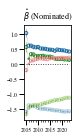

In [40]:
plot_compete('Nominated')

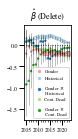

In [36]:
plot_compete('Delete')

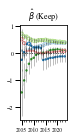

In [37]:
plot_compete('Keep')

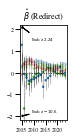

In [38]:
plot_compete('Redirect')

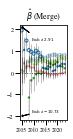

In [39]:
plot_compete('Merge')

# Study on the direction on Merge and Redirect

# Permutation Test

In [25]:
data_redirect_decision2_all = pd.read_csv('data/raw/data_redirect_decision2_all.csv', index_col=False)
data_merge_decision2_all = pd.read_csv('data/raw/data_merge_decision2_all.csv', index_col=False)

data_redirect_decision2_all3=data_redirect_decision2_all[data_redirect_decision2_all['QID2']!='no data']
data_merge_decision2_all3=data_merge_decision2_all[data_merge_decision2_all['QID2']!='no data']


data_redirect_decision2_all3['Gender']= data_redirect_decision2_all3['Gender'].apply(lambda x: 'Men' if x==0 else 'Women')
data_redirect_decision2_all3['instance of2']= data_redirect_decision2_all3.apply(lambda x: x['Gender2'] if x['instance of']=='human' else 'not human', axis=1)

data_merge_decision2_all3['Gender']= data_merge_decision2_all3['Gender'].apply(lambda x: 'Men' if x==0 else 'Women')
data_merge_decision2_all3['instance of2']= data_merge_decision2_all3.apply(lambda x: x['Gender2'] if x['instance of']=='human' else 'not human', axis=1)

In [27]:
def permutation_test_for_outcomes(data, option):

    
    men=data[data['Gender']=='Men'][['Gender','instance of2']]
    men['Gender of Alter']=men['instance of2'].apply(lambda x: 'same' if x=='male' else('opposite' if x=='female' else 'non-bios'))
    women=data[data['Gender']=='Women'][['Gender','instance of2']]
    women['Gender of Alter']=women['instance of2'].apply(lambda x: 'same' if x=='female' else('opposite' if x=='male' else 'non-bios'))
    biography_all= pd.concat([men.drop(columns=['instance of2']),women.drop(columns=['instance of2'])])

    biography_all
    contingency_table=pd.crosstab(biography_all['Gender'], biography_all['Gender of Alter'])
    contingency_table = contingency_table.rename_axis("Group", axis="index")
    table= contingency_table.div(contingency_table.sum(axis=1), axis=0)
    print(table)

    







    n_permutations = 1000
    perm_stats = []
    alter_column = option + '_to2'
    men_expected = []
    women_expected = []
    table3 =pd.DataFrame()


    for _ in nb.tqdm(range(n_permutations)):

        shuffled_data = data.copy()
        shuffled_data_part = pd.DataFrame(np.random.permutation(data[[alter_column,'instance of2']]), columns=[alter_column,'instance of2'])
        shuffled_data[alter_column]= shuffled_data_part[alter_column]
        shuffled_data['instance of2']= shuffled_data_part['instance of2']
        men=shuffled_data[shuffled_data['Gender']=='Men'][['Gender','instance of2']]
        men['Gender of Alter']=men['instance of2'].apply(lambda x: 'same' if x=='male' else('opposite' if x=='female' else 'non-bios'))
        women=shuffled_data[shuffled_data['Gender']=='Women'][['Gender','instance of2']]
        women['Gender of Alter']=women['instance of2'].apply(lambda x: 'same' if x=='female' else('opposite' if x=='male' else 'non-bios'))
        shuffled_data_biography= pd.concat([men.drop(columns=['instance of2']),women.drop(columns=['instance of2'])])
        contingency_table=pd.crosstab(shuffled_data_biography['Gender'], shuffled_data_biography['Gender of Alter'])
        contingency_table = contingency_table.rename_axis("Group", axis="index")
        table2=contingency_table.div(contingency_table.sum(axis=1), axis=0)
        table3=pd.concat([table3,table2])
    
   
    means=table3.groupby('Group').mean()
    stds=table3.groupby('Group').std()
    print(means)
    table3=table3.reset_index()
    men_tab=table3[table3['Group']=='Men']
    women_tab=table3[table3['Group']=='Women']
    
    return table,men_tab, women_tab

    
#     
    

In [28]:
table_re,men_tab_re, women_tab_re=permutation_test_for_outcomes(data_redirect_decision2_all3, 'redirect')

Gender of Alter  non-bios  opposite      same
Group                                        
Men              0.735579  0.013474  0.250947
Women            0.708553  0.111932  0.179514


  0%|          | 0/1000 [00:00<?, ?it/s]

Gender of Alter  non-bios  opposite      same
Group                                        
Men              0.772571  0.050787  0.176642
Women            0.784074  0.167828  0.048098


In [29]:
table_me,men_tab_me, women_tab_me=permutation_test_for_outcomes(data_merge_decision2_all3, 'merge')

Gender of Alter  non-bios  opposite      same
Group                                        
Men              0.583765  0.017271  0.398964
Women            0.458333  0.226852  0.314815


  0%|          | 0/1000 [00:00<?, ?it/s]

Gender of Alter  non-bios  opposite      same
Group                                        
Men              0.664014  0.073124  0.262862
Women            0.658093  0.267986  0.073921


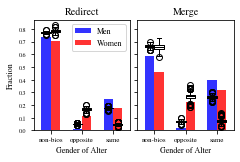

In [32]:
width = 3.125
height = width / 1.618
plt.rc('font', family='serif', serif='Times')
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=6)
plt.rc('axes', labelsize=8)
# set width of bar 
barWidth = 0.6
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True,sharey=True)

ax[0]=table_re.T.plot(kind='bar', ax=ax[0], color=['blue','red'], width=barWidth, alpha=.8)
xval= ax[0].get_xticks()

men_tab_re.boxplot( color='black', positions=[xval[0]-barWidth/4,xval[1]-barWidth/4,xval[2]-barWidth/4],grid=False, ax=ax[0])
women_tab_re.boxplot( color='black', positions=[xval[0]+barWidth/4,xval[1]+barWidth/4,xval[2]+barWidth/4],grid=False, ax=ax[0])
ticks = table_re.columns
ax[0].set_title("Redirect", fontsize=10)
ax[0].legend(fontsize=8)

ax[1]=table_me.T.plot(kind='bar', ax=ax[1], color=['blue','red'], width=barWidth, alpha=.8)
xval= ax[1].get_xticks()
men_tab_me.boxplot( color='black', positions=[xval[0]-barWidth/4,xval[1]-barWidth/4,xval[2]-barWidth/4],grid=False, ax=ax[1])
women_tab_me.boxplot( color='black', positions=[xval[0]+barWidth/4,xval[1]+barWidth/4,xval[2]+barWidth/4],grid=False, ax=ax[1])
ticks = table_me.columns


ax[1].set_title("Merge", fontsize=10)
ax[1].get_legend().remove()
plt.xticks(xval,ticks)
ax[0].set_ylabel('Fraction')
fig.tight_layout()
fig.set_size_inches(width, height)
fig.savefig('reports/figures/Fig6-Direction_to_merge_and_redirect.png', dpi=200, bbox_inches='tight')
fig.show()
